# Exercise 1.1.2
### Classification of MNIST digits with a convolutional neural network

In this exercise we will classify MNIST digits again, but this time we will use a convolutional neural network (CNN).

First we import the modules we need

In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We check that this script has a GPU available

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU. This is important so things run faster.


We import the MNIST dataset, which is built into pytorch

In [3]:
batch_size = 64

transformer = transforms.Compose([
    transforms.RandomRotation(100),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

trainset = datasets.MNIST('./data', train=True, download=True, transform=transformer)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

Augmented training data


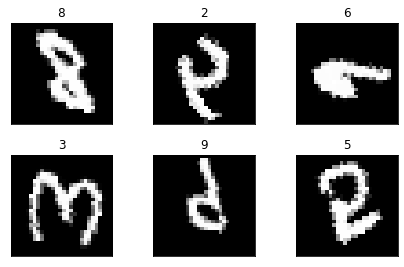

In [4]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print("Augmented training data")
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    fig

You should implement a network to classify MNIST digits. 
The network should consist of two parts, a part with convolutions and one with fully connected layers.
The convolutional part we will call `convolutional`, and it should contain the follwing:
* two convolutional layers with 8 features
* a $2\times2$ max pooling layer
* two convolutional layers with 16 features
* a fully connected layer

The convolutions should be $3\times 3$, and should not change the size of the output. What does this mean that the stride and padding should be?

Do for example check the documentation of the `nn` module https://pytorch.org/docs/stable/nn.html

In [8]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.Re
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU())

        self.fully_connected = nn.Sequential(
                nn.Linear(14*14*16, 500),
                nn.ReLU(),
                nn.Linear(500, 10),
                nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

We instantiate a copy of our network and transfer it to the GPU if it's available.

In [9]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

We train this network for five epochs

In [ ]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

Hopefully you now have a model that's able to achieve decent performance on MNIST.
It should have around 97.5% accuracy on the test set after the first epoch.

* Why does it have higher accuracy on the test set than the training set after the first epoch?

After the first epoch the neural net is remembering the specifities of the training set, which it has already met in the first epoch.

### Data augmentation
 * Add random rotations to the MNIST digits during training (you have to go back and modify the dataloader)
 
  hint: you can use `transforms.RandomRotation` 
  
  hint: you can combine multiple transforms into one with `transforms.Compose`

How does this affect your training and testing loss?

 * Try plotting some of the augmented images, to visually confirm what your augmentation is doing.

 * Try adding another type of data augmentation.

### Explore the model
What has the model learned? You can access all the weights in the model with `model.parameters()`. Here we just print the shape.
 - Try showing images of the filters in the first layer. 
 - Can you from the sizes alone identify which layer it is in our model?

In [92]:
[w.shape for w in model.parameters()]

[torch.Size([8, 1, 3, 3]),
 torch.Size([8]),
 torch.Size([8, 8, 3, 3]),
 torch.Size([8]),
 torch.Size([16, 8, 3, 3]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([500, 3136]),
 torch.Size([500]),
 torch.Size([10, 500]),
 torch.Size([10])]

In [93]:
params_ = [w for w in model.parameters()]

In [100]:
batch_idx, (example_data, example_targets) = next(examples)

print("Augmented training data")
# fig = plt.figure()
for i in range(6):
    print(example_data[i][0].shape)
#     plt.subplot(2,3,i+1)
#     plt.tight_layout()
#     plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("{}".format(example_targets[i]))
#     plt.xticks([])
#     plt.yticks([])
#     fig

Augmented training data
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


### Dropout
 * Try adding dropout to your model.
 
You can add it between the convolutional layers and or in the fully connected part.

Remember to call `net.train()` and `net.eval()` to change the model from test to training state, so it knows when you want it to apply dropout.